In [1]:
import os
import re
from collections import Counter
import string
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xuboy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xuboy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xuboy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xuboy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
coronaTweets = pd.read_csv('../00_source_data/CoronaTweet.csv', encoding='latin-1')
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
# collapse sentiment to 3 categories
coronaTweets['Sentiment'] = coronaTweets['Sentiment'].map({'Extremely Negative': 'Negative', 'Negative': 'Negative', 'Neutral': 'Neutral', 'Positive': 'Positive', 'Extremely Positive': 'Positive'})

In [4]:
coronaTweets['Sentiment'].value_counts()

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

## Preprocessing

convert to lower\
remove http link\
remove hashtag\
remove emoji\
remove stopwords\
remove punctuations\
Stemmer\
WordVectorize

In [5]:
# define preprocessing function
def preprocess(text):

    # lowercase
    text = text.lower()
    # remove http links
    text = re.sub(r'http\S+', '', text)
    # remove hashtags
    text = re.sub(r'#\S+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # only contain lowercaser 
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    return text

In [6]:
coronaTweets['text'] = coronaTweets['OriginalTweet'].apply(preprocess)
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbi philgahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,readi go supermarket outbreak im paranoid food...


In [7]:
# remove irrelevant columns
data = coronaTweets[['text','Sentiment']]

In [8]:
data.sample(10)

,text,Sentiment
2179,everyth go ive still receiv letter bt skyuk ra...,Negative
38767,walk top minut close suddenli found supermarke...,Positive
26281,struggl demand explod thank layoff,Neutral
40961,cut crude price hammer demand noon price obser...,Negative
41153,respons complaint provid cite covid relat dela...,Negative
22688,paper tube seed start easi athom activ whole f...,Positive
11254,supermarket shelv empti close bank close lpg g...,Negative
31123,couldnt find paracetamol pharmaci amp local su...,Positive
18840,need get cure got broke quarantin onlin shop b...,Neutral
5794,yesterday releas fiscal stimulu propos put epi...,Positive


In [9]:
# tokenize the text
data["split_data"] = data["text"].apply(
    lambda x: ["#S"] + word_tokenize(str(x)) + ["#E"]
)

In [10]:
data.sample(10)

,text,Sentiment,split_data
9072,come sainsburi supermarket shelv empti day her...,Negative,"[#S, come, sainsburi, supermarket, shelv, empt..."
40540,one thing duct tape cannot solv,Negative,"[#S, one, thing, duct, tape, can, not, solv, #E]"
14018,anhydr ammonia week last year price input like...,Positive,"[#S, anhydr, ammonia, week, last, year, price,..."
16979,pleas peopl tri minim food pharmaci shop less ...,Positive,"[#S, pleas, peopl, tri, minim, food, pharmaci,..."
13288,easi panic amp rightli consid deal sanit hand ...,Positive,"[#S, easi, panic, amp, rightli, consid, deal, ..."
37292,st norbert farmer market creat onlin option su...,Positive,"[#S, st, norbert, farmer, market, creat, onlin..."
19238,news mitch mcconnel crush democrat amp nanci p...,Negative,"[#S, news, mitch, mcconnel, crush, democrat, a..."
17515,fight hygien sanit paramount acquir self uniqu...,Positive,"[#S, fight, hygien, sanit, paramount, acquir, ..."
33230,stock price luxuri watch group rise spread slow,Neutral,"[#S, stock, price, luxuri, watch, group, rise,..."
2968,food stock employe recruit,Negative,"[#S, food, stock, employe, recruit, #E]"


In [11]:
# create labels for different sentiment. Negative:-1, Neutral: 0, Positive: 1
data['label'] = data['Sentiment'].apply(lambda x: 0 if x=='Neutral' else (1 if x=='Positive' else -1))

In [12]:
data

,text,Sentiment,split_data,label
0,menyrbi philgahan chrisitv,Neutral,"[#S, menyrbi, philgahan, chrisitv, #E]",0
1,advic talk neighbour famili exchang phone numb...,Positive,"[#S, advic, talk, neighbour, famili, exchang, ...",1
2,coronaviru australia woolworth give elderli di...,Positive,"[#S, coronaviru, australia, woolworth, give, e...",1
3,food stock one empti pleas dont panic enough f...,Positive,"[#S, food, stock, one, empti, pleas, dont, pan...",1
4,readi go supermarket outbreak im paranoid food...,Negative,"[#S, readi, go, supermarket, outbreak, im, par...",-1
...,...,...,...,...
41152,airlin pilot offer stock supermarket shelv loc...,Neutral,"[#S, airlin, pilot, offer, stock, supermarket,...",0
41153,respons complaint provid cite covid relat dela...,Negative,"[#S, respons, complaint, provid, cite, covid, ...",-1
41154,know get tough kameronwild ration toilet paper...,Positive,"[#S, know, get, tough, kameronwild, ration, to...",1
41155,wrong smell hand sanit start turn,Neutral,"[#S, wrong, smell, hand, sanit, start, turn, #E]",0


In [13]:
# calculate the frequency of the appereance of each word in different labels
dictionary = {}
for index, row in data.iterrows():
    text = set(row["split_data"])
    for word in text:
        # Parameters for naive bayes model, not as good as MultinomialNB, didn't use eventually
        # I leave it here for further optimization if interested in the future
        dictionary[word] = dictionary.get(word, {-1:0,1: 0, 0: 0})
        dictionary[word][row["label"]] += 1

In [14]:
dictionary

{'#S': {-1: 15398, 1: 18046, 0: 7713},
 'philgahan': {-1: 0, 1: 0, 0: 1},
 'chrisitv': {-1: 1, 1: 0, 0: 2},
 'menyrbi': {-1: 0, 1: 0, 0: 1},
 '#E': {-1: 15398, 1: 18046, 0: 7713},
 'suppli': {-1: 906, 1: 758, 0: 187},
 'contact': {-1: 114, 1: 201, 0: 35},
 'order': {-1: 326, 1: 533, 0: 167},
 'set': {-1: 131, 1: 155, 0: 65},
 'shop': {-1: 1414, 1: 2120, 0: 800},
 'neighbour': {-1: 30, 1: 33, 0: 7},
 'school': {-1: 99, 1: 134, 0: 40},
 'talk': {-1: 159, 1: 137, 0: 75},
 'account': {-1: 56, 1: 72, 0: 21},
 'creat': {-1: 108, 1: 238, 0: 11},
 'onlin': {-1: 855, 1: 1563, 0: 627},
 'exchang': {-1: 17, 1: 17, 0: 6},
 'gp': {-1: 7, 1: 12, 0: 3},
 'poss': {-1: 0, 1: 3, 0: 0},
 'chemist': {-1: 16, 1: 25, 0: 5},
 'regular': {-1: 39, 1: 68, 0: 22},
 'number': {-1: 144, 1: 214, 0: 22},
 'advic': {-1: 84, 1: 121, 0: 55},
 'employ': {-1: 54, 1: 71, 0: 18},
 'med': {-1: 14, 1: 19, 0: 4},
 'adequ': {-1: 8, 1: 29, 0: 1},
 'phone': {-1: 58, 1: 84, 0: 28},
 'list': {-1: 138, 1: 234, 0: 88},
 'famili': {-

In [15]:
# Construct three dictionaries for conditional probability for each individual word, given different labels
tempdict = [{},{},{}]
sentences = []
sentences.append(data[data["label"] == -1]["split_data"].values)
sentences.append(data[data["label"] == 0]["split_data"].values)
sentences.append(data[data["label"] == 1]["split_data"].values)

for i in range(3):
    for j in range(len(sentences[i])):
        tempdict[i][j]={}
        for t in range(len(sentences[i][j])):
            word = sentences[i][j][t]
            tempdict[i][j][word] = tempdict[i][j].get(word,[])
            tempdict[i][j][word].append(t)

In [16]:
def getConditionalProbability(word, tempdict, sentences):
    d = {}
    allNextWords = 0
    for i, value in tempdict.items():
        nextArr = value.get(word, [])
        for wordIndex in nextArr:
            try:
                nexWord = sentences[i][wordIndex + 1]
                d[nexWord] = d.get(nexWord, 0)
                d[nexWord] += 1
                allNextWords += 1
            except:
                pass
    d1 = {}
    for key, value in d.items():
        d1[key] = value / allNextWords
    return d1

In [17]:
# Calculate conditional probability for each word in different labels
conditionalProbDictLabel = [{},{},{}]
for i in range(3):
    for word in dictionary:
        conditionalProbDictLabel[i][word] = getConditionalProbability(word,tempdict[i],sentences[i])

In [18]:
conditionalProbDictLabel[0]

{'#S': {'readi': 0.000129886998311469,
  'corona': 0.0011040394856474867,
  'nation': 0.0011689829848032212,
  'downingstreet': 0.00038966099493440706,
  'prepar': 0.00019483049746720353,
  'morn': 0.0009092089881802832,
  'see': 0.0033770619560981948,
  'sealsoftheend': 6.49434991557345e-05,
  'countri': 0.0012988699831146902,
  'sorri': 0.0005844914924016106,
  'wife': 0.0006494349915573451,
  'check': 0.0011040394856474867,
  'south': 0.001039095986491752,
  'everyth': 0.000259773996622938,
  'stock': 0.0016235874788933628,
  'global': 0.0022080789712949733,
  'thing': 0.002078191972983504,
  'consum': 0.007988050396155345,
  'bought': 0.0004546044940901416,
  'seen': 0.0014287569814261593,
  'bobjlow': 6.49434991557345e-05,
  'action': 0.000259773996622938,
  'coronaviru': 0.009871411871671646,
  'thejoshuaturn': 6.49434991557345e-05,
  'open': 0.00019483049746720353,
  'want': 0.002273022470450708,
  'sadli': 0.00038966099493440706,
  'attempt': 0.00019483049746720353,
  'pleas': 

In [19]:
np.random.seed(0)

In [20]:
def getRandomWord(conditionalProbDictLabel, word):
    d = conditionalProbDictLabel[word]
    p = np.array(list(d.values()))
    # Look at np.random.choice: Given the prob distribution of next word, we random select word based on given probability
    if list(d.keys()) != []:
        nextWord = np.random.choice(list(d.keys()), p=p.ravel())
    else:
        nextWord = "#E"
    return nextWord

In [21]:
generateLabel = [[],[],[]]
for i in range(3):
    for j in range(5000):
        nextWord = getRandomWord(conditionalProbDictLabel[i], "#S")
        text = ["#S", nextWord]
        for t in range(500):  # sentence max lengh
            nextWord = getRandomWord(conditionalProbDictLabel[i], nextWord)
            text.append(nextWord)
            if nextWord == "#E":
                break
        generateLabel[i].append(text)

In [22]:
generateLabelText = []
label = [-1,0,1]
for i in range(3):
    for item in generateLabel[i]:
        if item[0] == "#S":
            item = item[1:]
        if item[-1] == "#E":
            item = item[:-1]
        generateLabelText.append({"label": label[i], "text": " ".join(item)})
generateLabelTextDf = pd.DataFrame(generateLabelText)

In [23]:
generateLabelTextDf

,label,text
0,-1,ga demand gun
1,-1,hello everyon tri cope pandem price impair fai...
2,-1,udelawar donat make sure eat scari shit
3,-1,call ts po amp want changestop stock food x
4,-1,priti patel
...,...,...
14995,1,team hard work groceri car
14996,1,sing amazon freshdirect say instal plexiglass ...
14997,1,pretti much possibl benefit provid rv advisor ...
14998,1,hi friend cant jump amid


In [24]:
generateLabelTextDf

,label,text
0,-1,ga demand gun
1,-1,hello everyon tri cope pandem price impair fai...
2,-1,udelawar donat make sure eat scari shit
3,-1,call ts po amp want changestop stock food x
4,-1,priti patel
...,...,...
14995,1,team hard work groceri car
14996,1,sing amazon freshdirect say instal plexiglass ...
14997,1,pretti much possibl benefit provid rv advisor ...
14998,1,hi friend cant jump amid


### Train Naive Bayes Classifier on real data

In [30]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)

# CounterVectizor
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# training classifier with NB
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

# print prediction and metrics on training set
y_pred_tr = nb.predict(X_train_cv)
print('Training set')
print('Accuracy: ', accuracy_score(y_train, y_pred_tr))
print('Confusion Matrix: ', confusion_matrix(y_train, y_pred_tr))
print('Classification Report: ', classification_report(y_train, y_pred_tr))
print('=====================================')

# print prediction and metrics on test set
y_pred_te = nb.predict(X_test_cv)
print('Test set')
print('Accuracy: ', accuracy_score(y_test, y_pred_te))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_te))
print('Classification Report: ', classification_report(y_test, y_pred_te))

Training set
Accuracy:  0.7924606893679058
Confusion Matrix:  [[ 9303   115  1403]
 [ 1230  2286  1905]
 [ 1195   131 11241]]
Classification Report:                precision    recall  f1-score   support

          -1       0.79      0.86      0.83     10821
           0       0.90      0.42      0.57      5421
           1       0.77      0.89      0.83     12567

    accuracy                           0.79     28809
   macro avg       0.82      0.73      0.74     28809
weighted avg       0.80      0.79      0.78     28809

Test set
Accuracy:  0.6781665046971169
Confusion Matrix:  [[3467   65 1045]
 [ 731  408 1153]
 [ 900   80 4499]]
Classification Report:                precision    recall  f1-score   support

          -1       0.68      0.76      0.72      4577
           0       0.74      0.18      0.29      2292
           1       0.67      0.82      0.74      5479

    accuracy                           0.68     12348
   macro avg       0.70      0.59      0.58     12348
weight

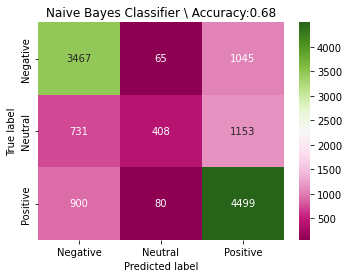

In [31]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_te)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="PiYG")
plt.title('Naive Bayes Classifier \ Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred_te)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save plot to file
plt.savefig('../30_results/NB_real_data.png')

### Train Naive Bayes Classifier on synthetic data

In [32]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(generateLabelTextDf['text'], generateLabelTextDf['label'], test_size=0.3, random_state=42)

# CounterVectizor
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# training classifier with NB
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

# print prediction and metrics on training set
y_pred_tr = nb.predict(X_train_cv)
print('Training set')
print('Accuracy: ', accuracy_score(y_train, y_pred_tr))
print('Confusion Matrix: ', confusion_matrix(y_train, y_pred_tr))
print('Classification Report: ', classification_report(y_train, y_pred_tr))
print('=====================================')

# print prediction and metrics on test set
y_pred_te = nb.predict(X_test_cv)
print('Test set')
print('Accuracy: ', accuracy_score(y_test, y_pred_te))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_te))
print('Classification Report: ', classification_report(y_test, y_pred_te))


Training set
Accuracy:  0.8306666666666667
Confusion Matrix:  [[2912  269  295]
 [ 307 2823  378]
 [ 273  256 2987]]
Classification Report:                precision    recall  f1-score   support

          -1       0.83      0.84      0.84      3476
           0       0.84      0.80      0.82      3508
           1       0.82      0.85      0.83      3516

    accuracy                           0.83     10500
   macro avg       0.83      0.83      0.83     10500
weighted avg       0.83      0.83      0.83     10500

Test set
Accuracy:  0.6862222222222222
Confusion Matrix:  [[1079  191  254]
 [ 265  922  305]
 [ 232  165 1087]]
Classification Report:                precision    recall  f1-score   support

          -1       0.68      0.71      0.70      1524
           0       0.72      0.62      0.67      1492
           1       0.66      0.73      0.69      1484

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg   

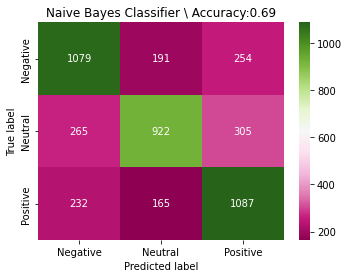

In [33]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_te)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="PiYG")
plt.title('Naive Bayes Classifier \ Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred_te)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save plot to file
plt.savefig('../30_results/NB_real_data.png')